<a href="https://colab.research.google.com/github/ArminD93/Intel-Image-Classification/blob/dev/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intel Image Classification**




In [1]:
%tensorflow_version 2.x
import os
import time
from datetime import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil # Pomaga w kopiowaniu plików
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(precision=12, suppress=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%load_ext tensorboard

In [0]:
# !unzip -q "/content/drive/My Drive/ColabNotebooks/intel_image/data/intel_image.zip" 

In [0]:
!rm -rf ./images

In [5]:
base_dir = './intel_image' # Przypisujemy katalog bazowy

raw_no_of_files = {}

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for dir in classes: # ile mamy zdjęć dla poszczególnych klas
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('buildings', 2628), ('forest', 2745), ('glacier', 2957), ('mountain', 3037), ('sea', 2784), ('street', 2883)])

In [0]:
# Utworzenie katalogów train, test, valid
data_dir = './images' # Przypisujemy katalog bazowy

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog dla zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog dla zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog dla  zbioru testowego

# Wskażemy klasy
train_buildings_dir = os.path.join(train_dir, 'buildings')
train_forest_dir = os.path.join(train_dir, 'forest')
train_glacier_dir = os.path.join(train_dir, 'glacier')
train_mountain_dir = os.path.join(train_dir, 'mountain')
train_sea_dir = os.path.join(train_dir, 'sea')
train_street_dir = os.path.join(train_dir, 'street')

valid_buildings_dir = os.path.join(valid_dir, 'buildings')
valid_forest_dir = os.path.join(valid_dir,    'forest'  )
valid_glacier_dir = os.path.join(valid_dir, 'glacier')
valid_mountain_dir = os.path.join(valid_dir, 'mountain')
valid_sea_dir = os.path.join(valid_dir, 'sea')
valid_street_dir = os.path.join(valid_dir, 'street')

test_buildings_dir = os.path.join(test_dir, 'buildings')
test_forest_dir = os.path.join(test_dir, 'forest')
test_glacier_dir = os.path.join(test_dir, 'glacier')
test_mountain_dir = os.path.join(test_dir, 'mountain')
test_sea_dir = os.path.join(test_dir, 'sea')
test_street_dir = os.path.join(test_dir, 'street')

# Pętla, która przejdzie po naszych katalogach
for i, directory in enumerate([train_dir, valid_dir, test_dir]):
    if not os.path.exists(directory): # Jeśli takie ścieżki nie istenieją, to po prostu utowrzymy te katalogi
        os.mkdir(directory)

# To samo wykonamy z katalogami w trzecim pozimie
dirs = [train_buildings_dir, train_forest_dir, train_glacier_dir, train_mountain_dir, train_sea_dir, train_street_dir,
        valid_buildings_dir, valid_forest_dir, valid_glacier_dir, valid_mountain_dir, valid_sea_dir, valid_street_dir,
        test_buildings_dir, test_forest_dir, test_glacier_dir, test_mountain_dir, test_sea_dir, test_street_dir 
        ]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)       

In [0]:
# Teraz musimy znać pełne ściżki do naszych plików
base_dir = './intel_image' # Przypisujemy katalog bazowy, gdzie są zdjęcia

# Do zmiennej _fnames przypisujemy wylistowanie katalogu z katalogu bazowego, tam gdzie są zdjęcia
buildings_files_names = os.listdir(os.path.join(base_dir, 'buildings')) 
forest_files_names = os.listdir(os.path.join(base_dir,    'forest'))
glacier_files_names = os.listdir(os.path.join(base_dir,   'glacier'))
mountain_files_names = os.listdir(os.path.join(base_dir,  'mountain'))
sea_files_names = os.listdir(os.path.join(base_dir,       'sea'))
street_files_names = os.listdir(os.path.join(base_dir,    'street'))

test_files_names = os.listdir(os.path.join(base_dir,      'test'))

In [0]:
# W kolejnym kroku określimy rozmiar danych, które będziemy potrzebować do naszego modelu.

# W związku z tym, że są różne wartości danych, w różnych klasach,
# Wybierzemy minimalną długość z tych dwóch klas i przypiszemy do zmiennej rozmiar
size = min(len(buildings_files_names), len(forest_files_names), len(glacier_files_names), len(mountain_files_names), len(sea_files_names), len(street_files_names))

train_size = int(np.floor(0.7 * size)) # rozmiar danych treningowych to 70% wszystkich zdjęć                                     
valid_size = int(np.floor(0.28 * size)) 
test_size = size - (train_size + valid_size) # Testowy zbiór to będzie 10%


In [9]:
def filesCopy(directory_dir):

  train_id = train_size
  valid_id = train_size + valid_size
  test_id = train_size + valid_size + test_size

  for i, dictio in enumerate(directory_dir):
    dir_name = [val for val in directory_dir.values() ][i]
    label_name = dictio
    
    for i, fname in enumerate(dir_name[0]):
        if i <= train_id:                                  
            src = os.path.join(base_dir, label_name, fname)   
            dst = os.path.join(dir_name[1], fname)
            shutil.copyfile(src, dst)
        elif train_id < i <= valid_id:
            src = os.path.join(base_dir, label_name, fname)
            dst = os.path.join(dir_name[2], fname)      
            shutil.copyfile(src, dst)
        elif valid_id < i < test_id:
            src = os.path.join(base_dir, label_name, fname)     
            dst = os.path.join(dir_name[3], fname)
            shutil.copyfile(src, dst)

    print(f'{label_name} - zbiór treningowy:  { len(os.listdir(dir_name[1] )) } ')
    print(f'{label_name} - zbiór walidacyjny: { len(os.listdir(dir_name[2] )) } ')
    print(f'{label_name} - zbiór testowy:     { len(os.listdir(dir_name[3] )) } ')
    print()
# ----------------------------------------------------------------------------------------------------

directory_dir = {
                  'buildings' : [buildings_files_names,  train_buildings_dir,  valid_buildings_dir,  test_buildings_dir ],
                  'forest'    : [forest_files_names,     train_forest_dir,     valid_forest_dir,     test_forest_dir    ],
                  'glacier'   : [glacier_files_names,    train_glacier_dir,    valid_glacier_dir,    test_glacier_dir   ],   
                  'mountain'  : [mountain_files_names,   train_mountain_dir,   valid_mountain_dir,   test_mountain_dir  ],   
                  'sea'       : [sea_files_names,        train_sea_dir,        valid_sea_dir,        test_sea_dir       ],   
                  'street'    : [street_files_names,     train_street_dir,     valid_street_dir,     test_street_dir    ]   
                }

filesCopy(directory_dir)  

buildings - zbiór treningowy:  1840 
buildings - zbiór walidacyjny: 735 
buildings - zbiór testowy:     53 

forest - zbiór treningowy:  1840 
forest - zbiór walidacyjny: 735 
forest - zbiór testowy:     53 

glacier - zbiór treningowy:  1840 
glacier - zbiór walidacyjny: 735 
glacier - zbiór testowy:     53 

mountain - zbiór treningowy:  1840 
mountain - zbiór walidacyjny: 735 
mountain - zbiór testowy:     53 

sea - zbiór treningowy:  1840 
sea - zbiór walidacyjny: 735 
sea - zbiór testowy:     53 

street - zbiór treningowy:  1840 
street - zbiór walidacyjny: 735 
street - zbiór testowy:     53 



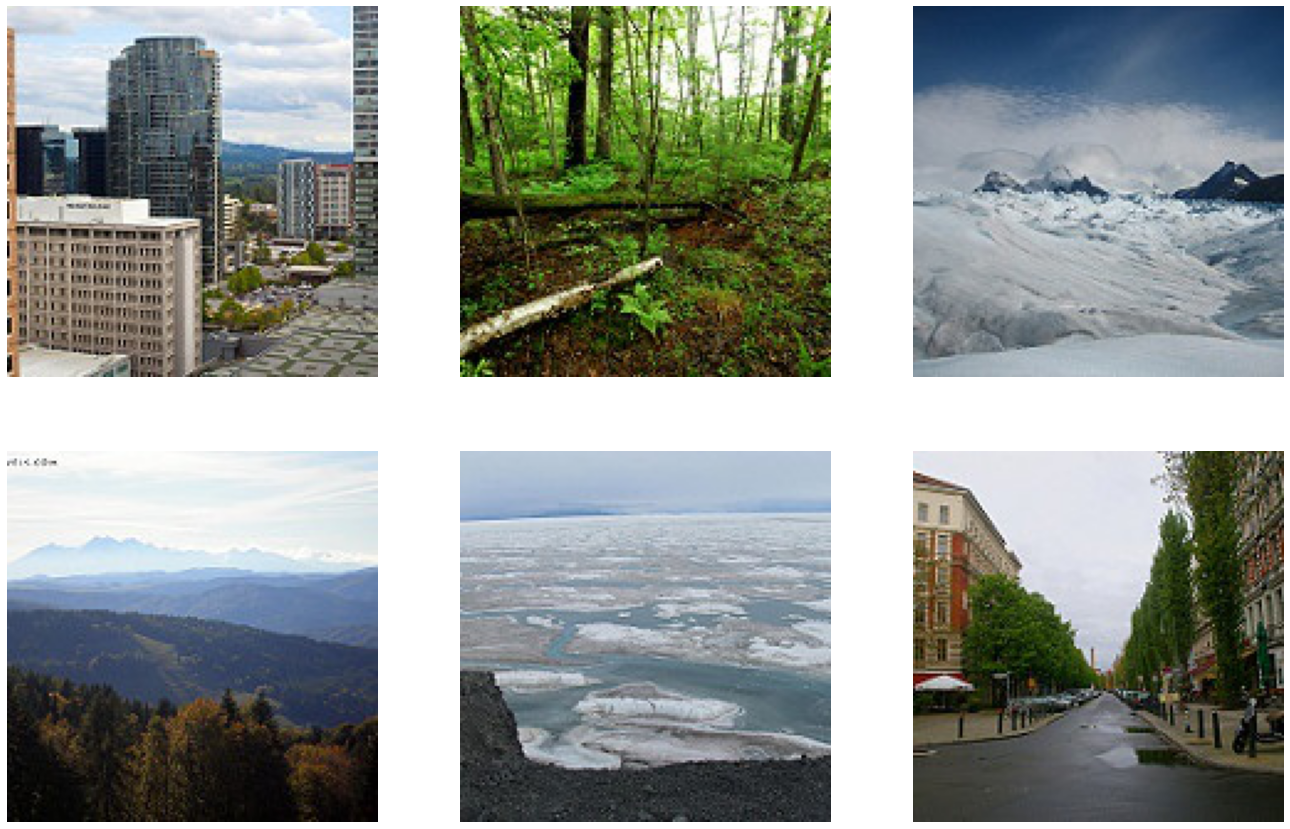

In [10]:
#@title Wybierz indeks przykładowego zdjęcia ze zbioru treningowego:

buildings_idx = 279 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(buildings_files_names))
img_path = os.path.join(train_buildings_dir, names_mapping[buildings_idx])
img_buildings = image.load_img(img_path)

forest_idx = 1302 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(forest_files_names))
img_path = os.path.join(train_forest_dir, names_mapping[forest_idx])
img_forest = image.load_img(img_path)

glacier_idx = 200 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(glacier_files_names))
img_path = os.path.join(train_glacier_dir, names_mapping[glacier_idx])
img_glacier = image.load_img(img_path)

mountain_idx = 1437 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(mountain_files_names))
img_path = os.path.join(train_mountain_dir, names_mapping[mountain_idx])
img_mountain = image.load_img(img_path)

sea_idx = 906 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(sea_files_names))
img_path = os.path.join(train_sea_dir, names_mapping[sea_idx])
img_sea = image.load_img(img_path)

street_idx = 766 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(street_files_names))
img_path = os.path.join(train_street_dir, names_mapping[street_idx])
img_street = image.load_img(img_path)

fig, ax = plt.subplots(2,3,figsize=(23, 15))

ax[0,0].imshow(img_buildings)
ax[0,1].imshow(img_forest)
ax[0,2].imshow(img_glacier)

ax[1,0].imshow(img_mountain)
ax[1,1].imshow(img_sea)
ax[1,2].imshow(img_street)


ax[0,0].axis(False)
ax[0,1].axis(False)
ax[0,2].axis(False)

ax[1,0].axis(False)
ax[1,1].axis(False)
ax[1,2].axis(False)

plt.show()

In [11]:
# Augmentacja danych

train_datagen = ImageDataGenerator(
    rotation_range=25,       # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,         # przeskalowujemy wszystkie obrazy o współczynnik 1/255
    width_shift_range=0.1,  # pionowe przekształcenia obrazu
    height_shift_range=0.1, # poziome przekształcenia obrazu
    shear_range=0.25,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,    # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'      # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

valid_datagen = ImageDataGenerator(rescale=1./255.) 

test_datagen = ImageDataGenerator(rescale=1./255.) 

#test_dir = '/content/intel_image/test'

# Budujemy generatory
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')  # batch size 32
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')                                           
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=16, class_mode='categorical', shuffle=False )

Found 11040 images belonging to 6 classes.
Found 4410 images belonging to 6 classes.
Found 318 images belonging to 6 classes.


In [0]:
def display_augmented_images(directory, index):

    files_names = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = files_names[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    
    plt.figure(figsize=(23, 10))

    image_no = 1
    for batch in train_datagen.flow(x, batch_size=1):
        if image_no == 16:
            break      
        plt.subplot(3, 5, image_no)
        plt.axis(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        image_no += 1


In [0]:
#@title Zbiór treningowy buildings:
index = 311 #@param {type:'slider', min:0, max:1839}  
  
display_augmented_images(train_buildings_dir, index)

In [0]:
#@title Zbiór treningowy forest:
index = 458 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_forest_dir, index)

In [0]:
#@title Zbiór treningowy glacier:
index = 66 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_glacier_dir, index)

In [0]:
#@title Zbiór treningowy mountain:
index = 77 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_mountain_dir, index)

In [0]:
#@title Zbiór treningowy sea:
index = 839 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_sea_dir, index)

In [0]:
#@title Zbiór treningowy street:
index = 635 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_street_dir, index)

In [0]:
class Network:
  
  def __init__(self, model_name, epochs, optimizer):
      self.model_name = model_name
      self.epochs = epochs
      self.optimizer = optimizer

  def model_summary(self):
          self.model_name.summary()

  def train(self, verbose=0, ):

      self.model_name.compile(optimizer= self.optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
      tz = 'CEST'
      log_dir = 'logs/' + dt.now().strftime('%Y-%m-%d_%H:%M:%S'+ tz) 
      tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1 )
      # --------------------------------------------------------
      time_start = time.time()
      self.history = self.model_name.fit( train_generator, steps_per_epoch= steps_per_epoch, epochs= self.epochs,
                          validation_data= valid_generator, validation_steps= validation_steps,
                          verbose= verbose, callbacks= [tensorboard, checkpoint]
                          )
      time_stop = time.time()
      print()
      print('Czas trenowania sieci: {} sek'.format(time_stop - time_start))
      # --------------------------------------------------------
      self.scores = self.model_name.evaluate(valid_generator, steps=validation_steps, verbose=0)
      print('Loss: {:.4f}'.format(self.scores[0]) )
      print('Accuracy: {:.4f}'.format(self.scores[1]) )

  def plot_hist(self, title):
      self.metric = 'accuracy'
      self.val_metric = 'val_accuracy'
      self.score = self.scores[1]

      sns.set_style("darkgrid")
      fig, axes = plt.subplots(1,2, figsize=(27,5))
      fig.suptitle(title)

      for self.i in range(2):
        if self.i == 1:
           self.metric = 'loss'
           self.val_metric = 'val_loss'
           self.score = self.scores[0]
        axes[self.i].plot(self.history.history[ self.val_metric], label= self.val_metric)
        axes[self.i].plot(self.history.history[ self.metric], label=  self.metric)
        axes[self.i].set(xlabel='epoki', ylabel= self.metric, title= self.metric+f': {self.score:.4f}')  
        axes[self.i].legend(loc='best')
      plt.show() 



In [0]:
!rm -rf ./logs

path ='/content/drive/My Drive/ColabNotebooks/intel_image/model/kopia/best_model.hdf5' 

checkpoint = ModelCheckpoint(filepath=path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)

batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [0]:
# ------------------------MODEL 1-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(visible)
y = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=8, kernel_size=1, activation='relu', padding='same')(y)

y = GlobalAveragePooling2D()(y)
output = Dense(6, activation='softmax')(y)

model_1 = Model(inputs=visible, outputs=output)
# ------------------------MODEL 2-------------------------------
y = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(visible)
y = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=64, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=64, kernel_size=1, activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=2)(y)
y = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(y)
y = Conv2D(filters=8, kernel_size=1, activation='relu', padding='same')(y)
y = Dropout(0.5)(y)

y = GlobalAveragePooling2D()(y)
output = Dense(6, activation='softmax')(y)

model_2 = Model(inputs=visible, outputs=output)

# ------------------------MODEL 3-------------------------------
y1 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(visible)
y1 = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y1)
y1 = MaxPooling2D(pool_size=2)(y1)

y2 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(visible)
y2 = Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(y2)
y2 = MaxPooling2D(pool_size=2)(y2)

y = concatenate([y1, y2])
y = GlobalAveragePooling2D()(y)
output = Dense(6, activation='softmax')(y)

model_3 = Model(inputs=visible, outputs=output)

# ------------------------MODEL 4-------------------------------
y = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(visible)
y = Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(y)
y = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(y)
y = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(y)
y = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)

y = GlobalAveragePooling2D()(y)
output = Dense(6, activation='softmax')(y)

model_4 = Model(inputs=visible, outputs=output)

# ------------------------MODEL 5-------------------------------
y1 = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same')(visible)
y1 = Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(y1)
y1= Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(y1)
y1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(y1)
y1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(y1)
y1 = MaxPooling2D(pool_size=(2, 2))(y1)
flat_1 = GlobalAveragePooling2D()(y1)

y2 = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same')(visible)
y2 = Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(y2)
y2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(y2)
y2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(y2)
y2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', padding='same')(y2)
y2 = MaxPooling2D(pool_size=(2, 2))(y2)
flat_2 = GlobalAveragePooling2D()(y2)

y = concatenate([flat_1, flat_2])
output = Dense(6, activation='softmax')(y)

model_5 = Model(inputs=visible, outputs=output)

In [16]:
modelObj_1 = Network(model_1, epochs=80, optimizer=RMSprop(lr=1e-4))
modelObj_2 = Network(model_2, epochs=80, optimizer=RMSprop(lr=1e-4))
modelObj_3 = Network(model_3, epochs=80, optimizer=RMSprop(lr=1e-4))
modelObj_4 = Network(model_4, epochs=80, optimizer=RMSprop(lr=1e-4))
modelObj_5 = Network(model_5, epochs=80, optimizer=RMSprop(lr=1e-4))

modelObj_1.model_summary()
modelObj_2.model_summary()
modelObj_3.model_summary()
modelObj_4.model_summary()
modelObj_5.model_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0     

In [17]:
modelObj_1.train(verbose=0)


Czas trenowania sieci: 841.5374603271484 sek
Loss: 0.9349
Accuracy: 0.6151


In [20]:
modelObj_2.train(verbose=0)


Czas trenowania sieci: 811.3557870388031 sek
Loss: 0.8819
Accuracy: 0.6547


In [21]:
modelObj_3.train(verbose=0)


Czas trenowania sieci: 803.7085933685303 sek
Loss: 1.4216
Accuracy: 0.4375


In [22]:
modelObj_4.train(verbose=0)


Czas trenowania sieci: 827.254252910614 sek
Loss: 0.8296
Accuracy: 0.6748


In [23]:
modelObj_5.train(verbose=0)


Czas trenowania sieci: 846.703736782074 sek
Loss: 1.0196
Accuracy: 0.6264


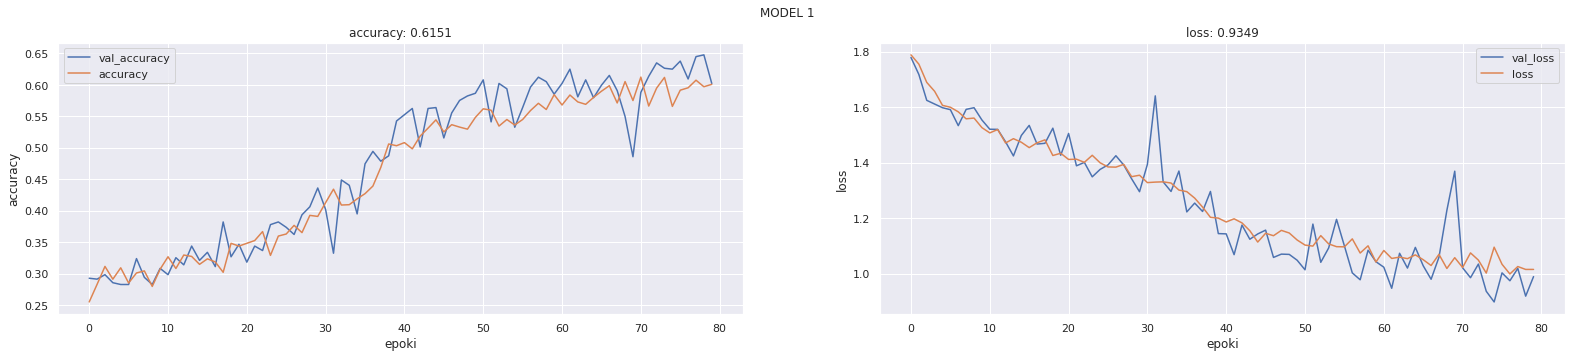

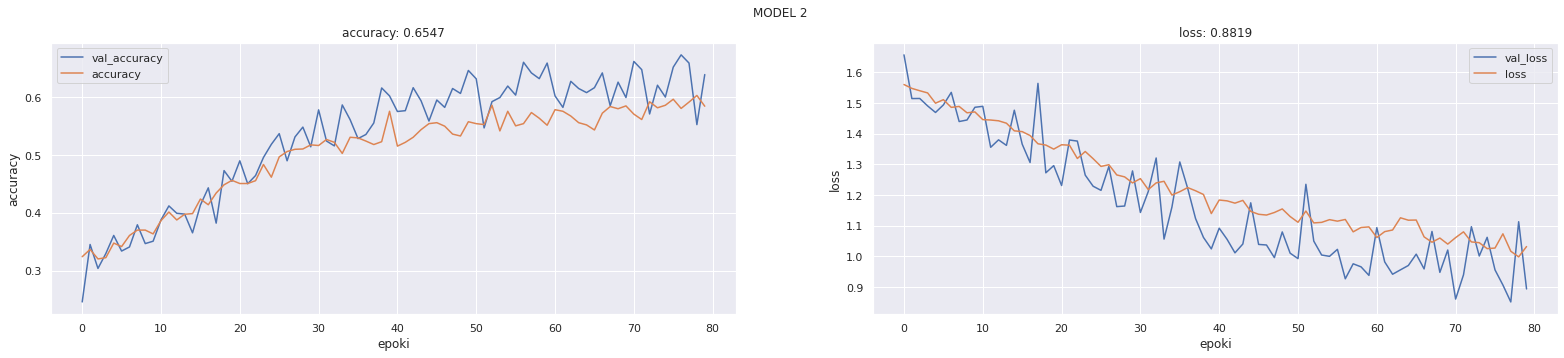

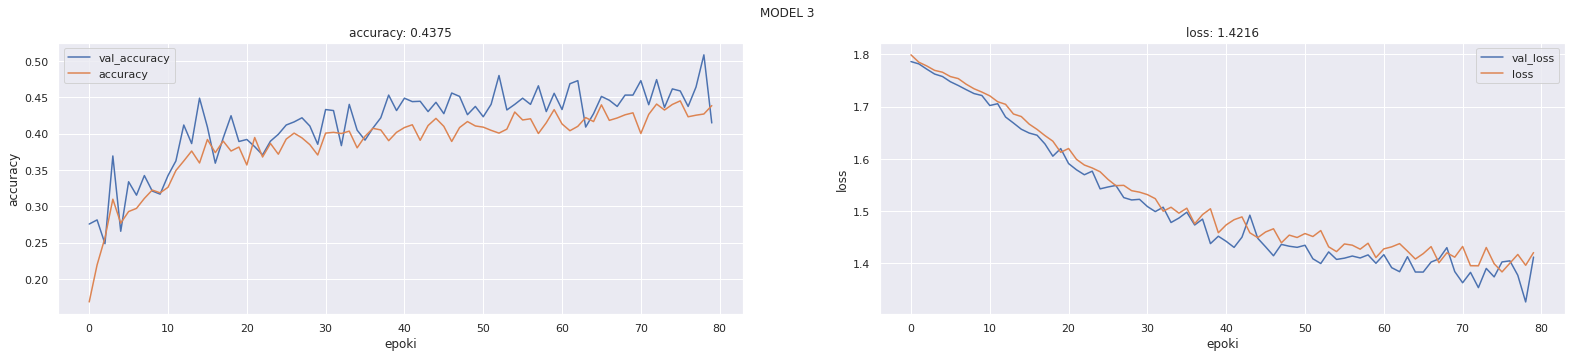

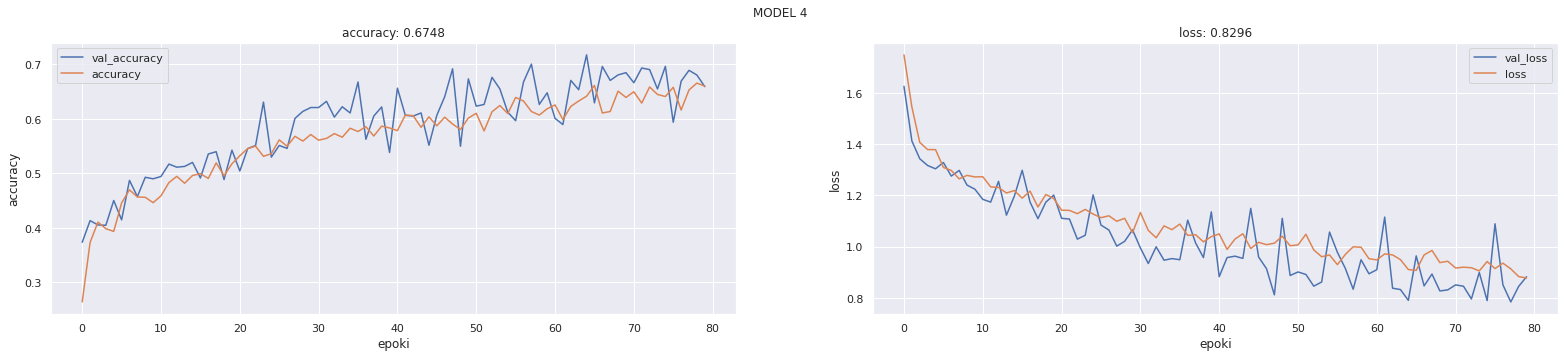

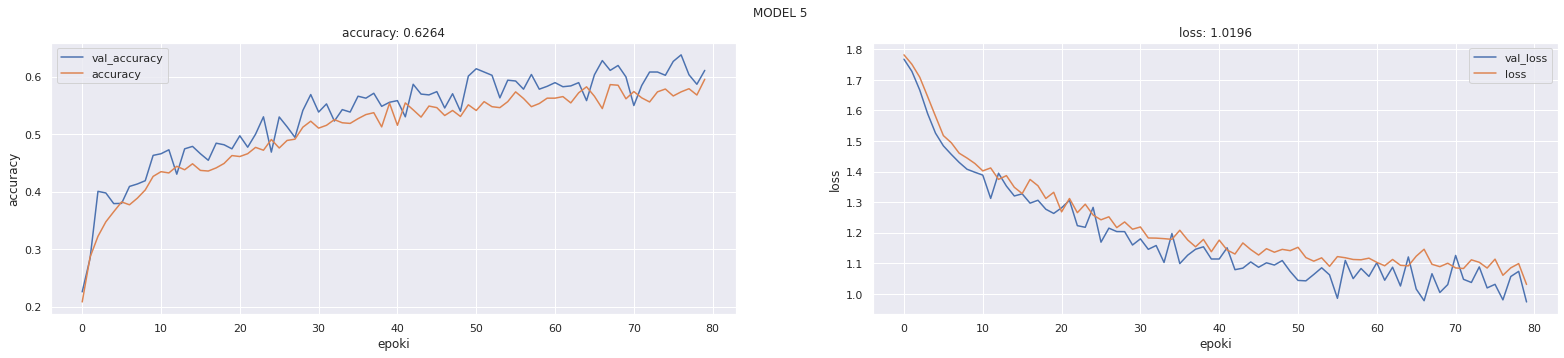

In [24]:
modelObj_1.plot_hist(title='MODEL 1')
modelObj_2.plot_hist(title='MODEL 2')
modelObj_3.plot_hist(title='MODEL 3')
modelObj_4.plot_hist(title='MODEL 4')
modelObj_5.plot_hist(title='MODEL 5')

In [0]:
# %tensorboard --logdir logs

In [0]:
best_model = load_model('/content/drive/My Drive/ColabNotebooks/intel_image/model/kopia/best_model.hdf5')

best_model.summary()

In [0]:
y_prob = model.predict(test_generator, test_generator.samples) # Stosujemy predict_generator() aby otrzymać predykcje naszych klas

# Nasza predykcja zwraca nam prawdopobieństwa przynależności do poszczególnej klasy
y_prob

Found 318 images belonging to 6 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


array([[0.9986633     , 0.000000978753, 0.000003771946, 0.000005314024,
        0.000017367178, 0.0013092916  ],
       [0.9465309     , 0.0023732674  , 0.000057400903, 0.0000902689  ,
        0.0003007469  , 0.05064744    ],
       [0.99594575    , 0.000001535091, 0.000020245212, 0.004024383   ,
        0.000000513015, 0.000007612864],
       ...,
       [0.1133016     , 0.099852204   , 0.00029040902 , 0.00013196582 ,
        0.000018889057, 0.78640497    ],
       [0.005294126   , 0.000069025074, 0.00001660287 , 0.000007617246,
        0.000030385012, 0.99458224    ],
       [0.0039808974  , 0.9798625     , 0.00012075454 , 0.00001117491 ,
        0.000014636397, 0.01601014    ]], dtype=float32)

In [0]:
# Meotoda argmax() zwróci nam argument gdzie dana tablica przyjmuje wartość maksymalną
# To będą nasze predykcje
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 4, 2, 3, 0, 2, 2, 2, 2, 3,
       3, 0, 3, 2, 5, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 0, 2, 4, 3, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 4, 3, 4, 4, 4, 2, 4, 4, 0, 4, 4, 4, 2, 4,
       4, 4, 0, 0, 4, 0, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 1, 5, 0, 5, 5, 5, 5, 5, 5,
       5, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 0, 5,

In [0]:
predictions  = pd.DataFrame({'Class': y_pred})
predictions

,Class
0,0
1,0
2,0
3,0
4,0
...,...
313,5
314,5
315,5
316,5


In [0]:
# Prawdziwe klasy, które były przypisane do naszego zbioru testowego
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [0]:
y_pred = predictions['Class'].values
y_pred

array([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 4, 2, 3, 0, 2, 2, 2, 2, 3,
       3, 0, 3, 2, 5, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 0, 2, 4, 3, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 4, 3, 4, 4, 4, 2, 4, 4, 0, 4, 4, 4, 2, 4,
       4, 4, 0, 0, 4, 0, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 1, 5, 0, 5, 5, 5, 5, 5, 5,
       5, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 0, 5,

In [0]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

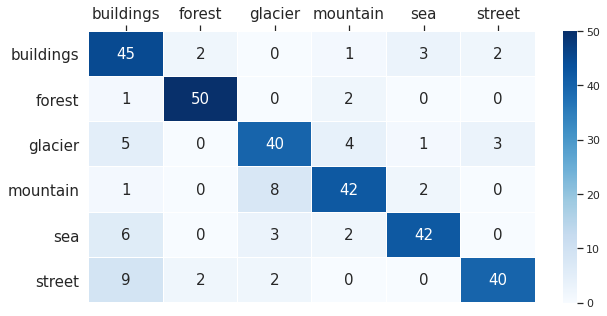

In [0]:
# Tworzymy macierz konfucji, która powie nam jak wygląda klasyfikacja
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 5))
g = sns.heatmap(cm, annot=True, fmt='d', linewidth=.2, cmap='Blues',
                xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(),
                annot_kws={"size": 15})

g.tick_params(labelsize=15)
g.xaxis.tick_top()
plt.yticks(rotation=0) 
plt.xticks(rotation=0) 
plt.show()

In [0]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

   buildings       0.67      0.85      0.75        53
      forest       0.93      0.94      0.93        53
     glacier       0.75      0.75      0.75        53
    mountain       0.82      0.79      0.81        53
         sea       0.88      0.79      0.83        53
      street       0.89      0.75      0.82        53

    accuracy                           0.81       318
   macro avg       0.82      0.81      0.82       318
weighted avg       0.82      0.81      0.82       318



In [0]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
buildings/10161.jpg,0,0
buildings/10318.jpg,0,0
buildings/11568.jpg,0,0
buildings/12231.jpg,0,0
buildings/12290.jpg,0,0


In [0]:
# Dodamy jeszcze jedną kolumnę.
# Tutaj sprawdzimy, czy te wartości się różnią.
# Jeśli się różnią, to zwrócimy wartość 1

errors['incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,incorrect
buildings/10161.jpg,0,0,0
buildings/10318.jpg,0,0,0
buildings/11568.jpg,0,0,0
buildings/12231.jpg,0,0,0
buildings/12290.jpg,0,0,0
...,...,...,...
street/7585.jpg,5,5,0
street/7601.jpg,5,5,0
street/807.jpg,5,5,0
street/8844.jpg,5,5,0


In [0]:
# obiekty błędnie sklasyfikowane
errors[errors['incorrect'] == 1].index

Index(['buildings/12315.jpg', 'buildings/14004.jpg', 'buildings/17332.jpg',
       'buildings/1760.jpg', 'buildings/17821.jpg', 'buildings/21719.jpg',
       'buildings/2362.jpg', 'buildings/3387.jpg', 'forest/10281.jpg',
       'forest/12657.jpg', 'forest/1705.jpg', 'glacier/15468.jpg',
       'glacier/17323.jpg', 'glacier/22625.jpg', 'glacier/23096.jpg',
       'glacier/4880.jpg', 'glacier/6109.jpg', 'glacier/6279.jpg',
       'glacier/6516.jpg', 'glacier/8098.jpg', 'glacier/8119.jpg',
       'glacier/8216.jpg', 'glacier/861.jpg', 'glacier/893.jpg',
       'mountain/11497.jpg', 'mountain/11750.jpg', 'mountain/18737.jpg',
       'mountain/19499.jpg', 'mountain/19927.jpg', 'mountain/3070.jpg',
       'mountain/4554.jpg', 'mountain/4579.jpg', 'mountain/4771.jpg',
       'mountain/5924.jpg', 'mountain/6079.jpg', 'sea/11039.jpg',
       'sea/15880.jpg', 'sea/1723.jpg', 'sea/18920.jpg', 'sea/20696.jpg',
       'sea/21860.jpg', 'sea/2740.jpg', 'sea/3221.jpg', 'sea/4383.jpg',
       'sea/463

In [0]:
len(errors[errors['incorrect'] == 1].index)

59

(-0.5, 149.5, 149.5, -0.5)

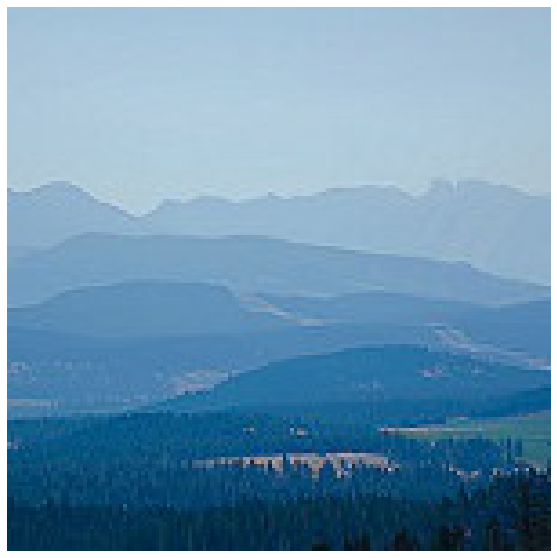

In [0]:
# Wyświeltimy przykładowe zdjęcia
# new_test_dir = './images/test/new_test/'

img_path = os.path.join(test_forest_dir, '1705.jpg') 

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis(False)